In [6]:
import torch
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader

from Model.MaskRCNN import PreMaskRCNN, MaskRCNN_MobileNet_v2_bn
from Dataset import PennFudanDataset
from reference.detection import utils

from reference.detection.engine import train_one_epoch, evaluate

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.io import read_image

torch.manual_seed(123)

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [17]:
# Main train code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 2

ds_train = PennFudanDataset(get_transform(train=True))
ds_valid = PennFudanDataset(get_transform(train=False))

# Split the dataset in train and valid set

indices = torch.randperm(len(ds_train)).tolist()

ds_train = torch.utils.data.Subset(ds_train, indices[:-50])
ds_valid = torch.utils.data.Subset(ds_valid, indices[-50:])

dl_train= DataLoader(ds_train, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
dl_valid= DataLoader(ds_valid, batch_size=1, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

# model = PreMaskRCNN().to(device)
model = MaskRCNN_MobileNet_v2_bn().to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=5e-3, momentum=0.9, weight_decay=5e-4)

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 20

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, dl_train, device, epoch, print_freq=10)

    lr_scheduler.step()

    evaluate(model, dl_valid, device=device)


Epoch: [0]  [ 0/60]  eta: 0:00:26  lr: 0.000090  loss: 4.2903 (4.2903)  loss_classifier: 0.6883 (0.6883)  loss_box_reg: 0.0746 (0.0746)  loss_mask: 2.8262 (2.8262)  loss_objectness: 0.6663 (0.6663)  loss_rpn_box_reg: 0.0348 (0.0348)  time: 0.4390  data: 0.2477  max mem: 6113
Epoch: [0]  [10/60]  eta: 0:00:10  lr: 0.000936  loss: 3.8158 (3.6351)  loss_classifier: 0.6418 (0.6192)  loss_box_reg: 0.0779 (0.0704)  loss_mask: 2.3979 (2.2371)  loss_objectness: 0.6646 (0.6602)  loss_rpn_box_reg: 0.0348 (0.0482)  time: 0.2159  data: 0.0241  max mem: 6113
Epoch: [0]  [20/60]  eta: 0:00:08  lr: 0.001783  loss: 2.4844 (2.9280)  loss_classifier: 0.4261 (0.4720)  loss_box_reg: 0.0882 (0.1004)  loss_mask: 1.3473 (1.6892)  loss_objectness: 0.6292 (0.6238)  loss_rpn_box_reg: 0.0310 (0.0426)  time: 0.1939  data: 0.0019  max mem: 6113
Epoch: [0]  [30/60]  eta: 0:00:06  lr: 0.002629  loss: 1.7898 (2.5089)  loss_classifier: 0.2698 (0.4003)  loss_box_reg: 0.1436 (0.1165)  loss_mask: 0.8157 (1.3862)  loss_ob

(-0.5, 566.5, 437.5, -0.5)

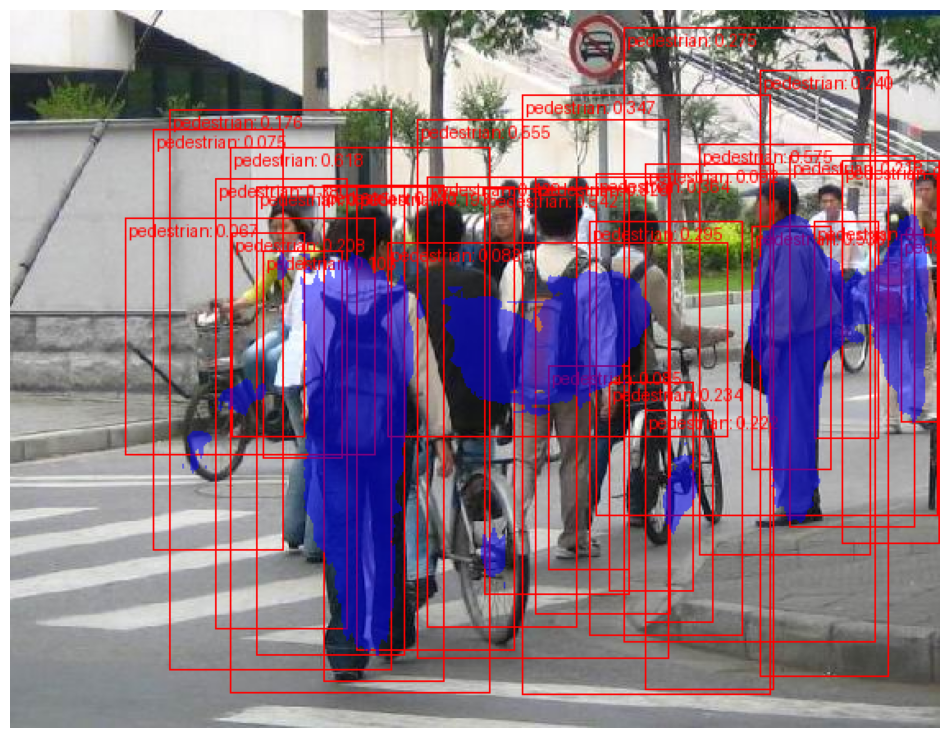

In [8]:
view_img = read_image('../../Data/PennFudanPed/PNGImages/FudanPed00046.png')
eval_transform = get_transform(train=False)

model.eval()

with torch.no_grad():
    images = eval_transform(view_img)
    images = images[:3, ...].to(device)
    preds = model([images,])

pred = preds[0]
view_img = (255.0*(view_img - view_img.min()) / (view_img.max() - view_img.min())).to(torch.uint8)
view_img = view_img[:3, ...]

pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()

output_image = draw_bounding_boxes(view_img, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.axis('off')

(-0.5, 486.5, 537.5, -0.5)

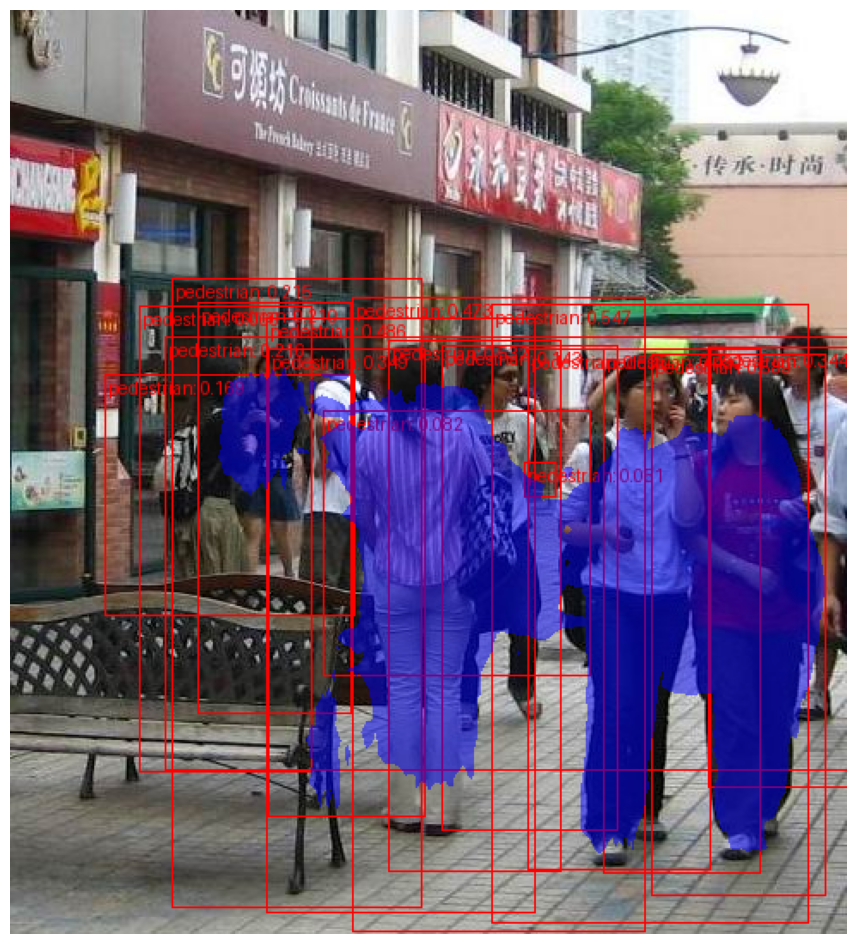

In [9]:
view_img = read_image('../../Data/PennFudanPed/PNGImages/FudanPed00045.png')
eval_transform = get_transform(train=False)

model.eval()

with torch.no_grad():
    images = eval_transform(view_img)
    images = images[:3, ...].to(device)
    preds = model([images,])

pred = preds[0]
view_img = (255.0*(view_img - view_img.min()) / (view_img.max() - view_img.min())).to(torch.uint8)
view_img = view_img[:3, ...]

pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()

output_image = draw_bounding_boxes(view_img, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.axis('off')

(-0.5, 471.5, 519.5, -0.5)

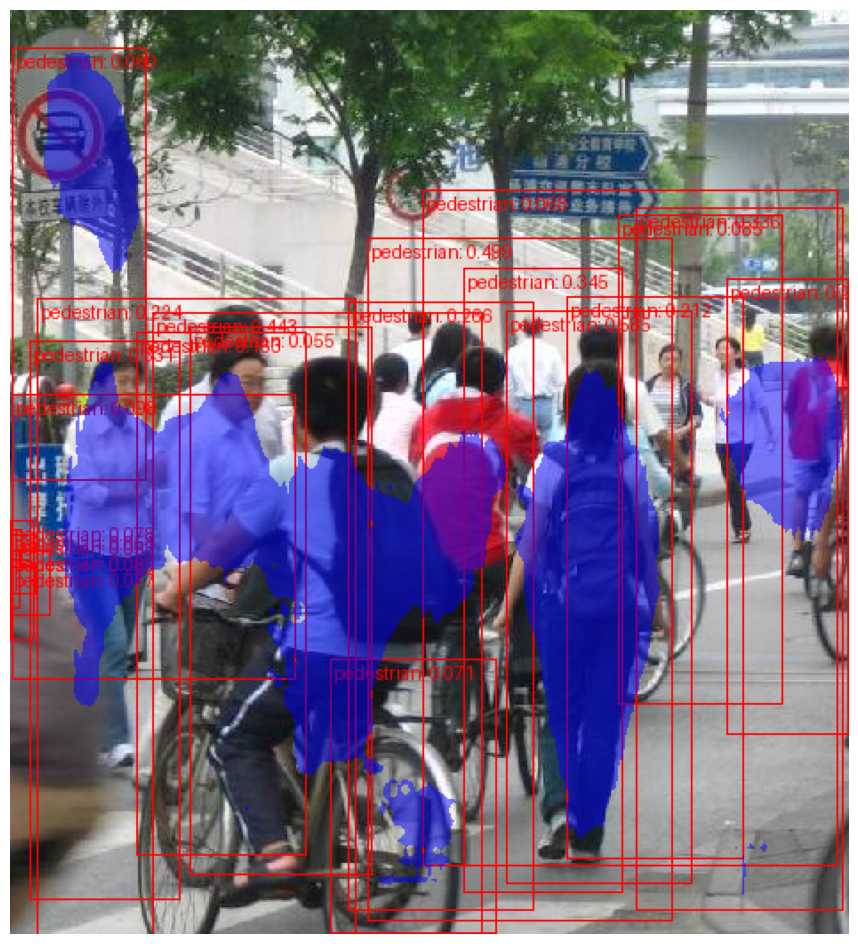

In [10]:
view_img = read_image('../../Data/PennFudanPed/PNGImages/FudanPed00047.png')
eval_transform = get_transform(train=False)

model.eval()

with torch.no_grad():
    images = eval_transform(view_img)
    images = images[:3, ...].to(device)
    preds = model([images,])

pred = preds[0]
view_img = (255.0*(view_img - view_img.min()) / (view_img.max() - view_img.min())).to(torch.uint8)
view_img = view_img[:3, ...]

pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()

output_image = draw_bounding_boxes(view_img, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.axis('off')